# RAG Based on RAG-Fusion
- Hybrid Search
- ReRanker
- RAG-Fusion

## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Bedrock Client 생성

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models())

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3 모델 로딩

### LLM 로딩 (Claude-v3)

In [41]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

수익률 그래프 이해하기
수익률 그래프 분석 방법수익률 그래프 설명 방법
수익률 그래프 이해하기1. 수익률 그래프 해석 방법
2. 수익률 그래프 이해하기

In [42]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
    },
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7fcb41be4d60>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7fcac6d5fa60>])

### Embedding 모델 선택

In [43]:
from utils.rag import KoSimCSERobertaContentHandler, SagemakerEndpointEmbeddingsJumpStart

In [44]:
def get_embedding_model(is_bedrock_embeddings, is_KoSimCSERobert, aws_region, endpont_name=None):
    
    if is_bedrock_embeddings:
        # We will be using the Titan Embeddings Model to generate our Embeddings.
        from langchain.embeddings import BedrockEmbeddings
        llm_emb = BedrockEmbeddings(
            client=boto3_bedrock,
            model_id=bedrock_info.get_model_id(
                model_name="Titan-Embeddings-G1"
            )
        )
        print("Bedrock Embeddings Model Loaded")

    elif is_KoSimCSERobert:
        LLMEmbHandler = KoSimCSERobertaContentHandler()
        endpoint_name_emb = endpont_name
        llm_emb = SagemakerEndpointEmbeddingsJumpStart(
            endpoint_name=endpoint_name_emb,
            region_name=aws_region,
            content_handler=LLMEmbHandler,
        )        
        print("KoSimCSERobert Embeddings Model Loaded")
    else:
        llm_emb = None
        print("No Embedding Model Selected")
    
    return llm_emb

#### [중요] is_KoSimCSERobert == True 일시에 endpoint_name 을 꼭 넣어 주세요.

In [45]:
is_bedrock_embeddings = True
is_KoSimCSERobert = False
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

##############################
# Parameters for is_KoSimCSERobert
##############################
if is_KoSimCSERobert: endpont_name = "<endpoint-name>"
else: endpont_name = None
##############################

llm_emb = get_embedding_model(is_bedrock_embeddings, is_KoSimCSERobert, aws_region, endpont_name)   

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [46]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

In [47]:
depoly = False

In [48]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [49]:
import boto3
from utils.ssm import parameter_store

In [50]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [15]:
pm.put_params(
    key="reranker_endpoint",
    value=f'{predictor.endpoint}',
    overwrite=True,
    enc=False
)

NameError: name 'predictor' is not defined

## 4. Invocation (prediction)

In [51]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7fcb30beb730>


In [52]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [53]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [54]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.999653697013855}, {'label': 'LABEL_0', 'score': 0.025255175307393074}]
CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 90.7 ms


## 5. LangChainmOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [55]:
import boto3
from utils.ssm import parameter_store

In [56]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [57]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [58]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [59]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: kb_complex_pdf


### OpenSearch Client 생성

In [60]:
from utils.opensearch import opensearch_utils

In [61]:
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 6. Retriever based on Hybrid Search + RAG-Fusion + ReRanker
- LangChain에서 제공하는 **BaseRetriever** 클래스를 상속받아 **Custom Retriever**를 정의 할 수 있습니다.
- Hybrid-Search에 대한 자세한 내용는 **"01_rag_hybrid_search.ipyno"** 에서 확인 가능합니다.
- [RAG-Fusion](https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1)
![rag-fusion.png](../../../imgs/rag-fusion.png)

In [62]:
from utils.rag import OpenSearchHybridSearchRetriever

- 필터 설정 예시
- filter=[ <BR>
    　{"term": {"metadata.[**your_metadata_attribute_name**]": "**your first keyword**"}}, <BR>
    　{"term": {"metadata.[**your_metadata_attribute_name**]": "**your second keyword**"}},<BR>
]

In [63]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    # necessary
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in rag_fusion
    llm_emb=llm_emb,

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.5, .5], # [for lexical, for semantic], Lexical, Semantic search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    rag_fusion=True, # enable rag_fusion
    query_augmentation_size=3, # query_augmentation_size in rag_fusion
    
    # option for async search
    async_mode=False,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=True
)

### Retrieval example
- default search

In [64]:
from utils.rag import show_context_used

In [65]:
query = "중지된 경우 이체"

In [66]:
%%time
search_hybrid_result = opensearch_hybrid_retriever.get_relevant_documents(query)

print("\n==========  Results  ==========\n")
print(f'1. question: {query}')
print (f'2. # documents: {len(search_hybrid_result)}')
print("3. Documents: \n")

show_context_used(search_hybrid_result)

이체 거절 사유
이체 실패 원인
이체 오류 해결 방법

===== RAG-Fusion Queries =====
['중지된 경우 이체', '이체 거절 사유', '이체 실패 원인', '이체 오류 해결 방법']

[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1

##############################
async_mode
##############################
False
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
True
##############################
HyDE
##############################
False
##############################
parent_document
##############################
False
##############################
complex_document
##############################
False
#####

- update parameters

In [67]:
opensearch_hybrid_retriever.update_search_params(
    k=10,
    minimum_should_match=30,
    filter=[
        #{"term": {"metadata.project": "KS"}},
    ],
    reranker=True,
    reranker_endpoint_name=endpoint_name,
    rag_fusion=True, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    llm_text=llm_text, # llm for query augmentation in rag_fusion
    verbose=True
)

은행 이체 중지 사유
계좌이체 중지 문제 해결

===== RAG-Fusion Queries =====
['중지된 경우 이체', '은행 이체 중지 사유', '계좌이체 중지 문제 해결']

[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1

##############################
async_mode
##############################
False
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
True
##############################
HyDE
##############################
False
##############################
parent_document
##############################
False
####################

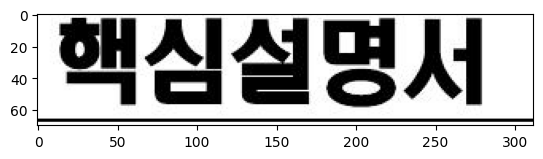

주어진 이미지는 한국어로 "핵실설명서"라는 문구를 보여주고 있습니다. 이 문구는 일반적으로 핵무기와 관련된 내용일 가능성이 있습니다. 그러나 이미지에서 세부 내용을 확인할 수 없기
때문에 정확한 내용을 파악하기는 어렵습니다.
metadata:
 {'img_path': './fig/figure-1-1.jpg', 'category': 'Image', 'image_base64': '', 'id':
'7a4751eb-2442-4aa0-8e2d-2295b1c29af3', 'origin_image': ''}

-----------------------------------------------
3. Category: Image, Chunk: 151 Characters
-----------------------------------------------


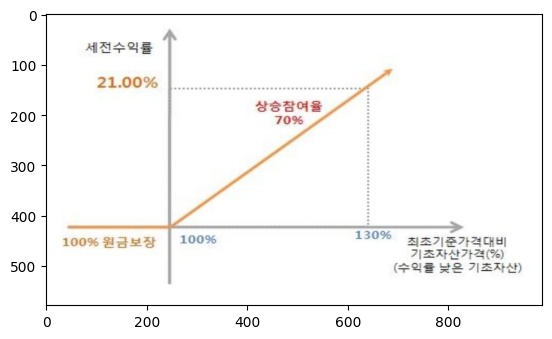

이 그래프는 적주기준가격대비 기준자산가격(%)에 따른 상승률여율을 보여주고 있습니다. 원금보전 100%에서는 상승률이 0%이지만, 적주기준가격대비가 130%로 높아질수록
상승률여율은 최대 21%까지 증가합니다. 이를 통해 위험과 수익 간의 상관관계를 확인할 수 있습니다.
metadata:
 {'img_path': './fig/figure-3-3.jpg', 'category': 'Image', 'image_base64': '', 'id':
'2d32a0bf-5325-4a32-9d5f-43290b23ae1a', 'origin_image': ''}

-----------------------------------------------
4. Category: CompositeElement, Chunk: 457 Characters
-----------------------------------------------
8 기타 유의 사항 ○ 투자설명서 효력발생일 : 2011. 07. 01 ○ 투자설명서 열람장소 : http://dart.fss.or.kr 및 미래에셋증권 본지점 ○ 청약개시일까지는
수리되어 효력이 발생하였다고 하여 정부가 그 기재사항이 진실 또는 정확하다는 것을 인정하거나 당해 유가증권의 가치를 보증 또는 승인하는 것은 아닙니다. ○ 공모결과 총 청약금액이
모집금액의 100%이상인 경우 청약금액에 비례하여 안분배정합니다. ※ 상품가입 후 의문사항은 고객지원센터(1588-9200), 불만(민원)이 있을 경우
컴플라이언스팀(02-3774-1309) 또는 인터넷 홈페이지에 문의할 수 있고, 분쟁이 발생한 경우에는 금융감독원(국번없이 1332) 등의 도움을 요청할 수 있습니다. ○ 본
상품의 발행조건과 기준가격은 당사홈페이지( http://www.miraeassetaccount.com )에서 확인하실 수 있습니다.
metadata:
 {'source': './data/complex_pdf/sample.pdf', 'filetype': 'application/pdf',

In [68]:
query = "중지된 경우 이체"
search_hybrid_result = opensearch_hybrid_retriever.get_relevant_documents(query)

print("\n==========  Results  ==========\n")
print(f'1. question: {query}')
print(f'2. # documents: {len(search_hybrid_result)}')
print("3. Documents: \n")

show_context_used(search_hybrid_result)

## 5. RAG using RetrievalQA powered by LangChain

In [69]:
from utils.rag import prompt_repo

### Prompting
- [TIP] Prompt의 instruction의 경우 한글보다 영어로 했을 때 더 좋은 결과를 얻을 수 있습니다.

In [70]:
system_prompt = prompt_repo.get_system_prompt()
pprint (system_prompt)

('\n'
 '                        You are a master answer bot designed to answer '
 "user's questions.\n"
 "                        I'm going to give you contexts which consist of "
 'texts, tables and images.\n'
 "                        Read the contexts carefully, because I'm going to "
 'ask you a question about it.\n'
 '                        ')


### Update Search Params (Optional)

In [74]:
from utils.rag import qa_chain
from langchain.schema.output_parser import StrOutputParser

In [94]:
opensearch_hybrid_retriever.update_search_params(
    k=3,
    minimum_should_match=0,
    filter=[],
    reranker=True,
    reranker_endpoint_name=endpoint_name,
    rag_fusion=True, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    llm_text=llm_text, # llm for query augmentation in rag_fusion
    async_mode=False,
    verbose=True
)

### Request

In [95]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=True
)

In [ ]:
query = "중지된 경우 이체"
#query = "vidio max size?"
query = "수익률 그래프를 설명해줘"
response, contexts = qa.invoke(
    query = query
)

show_context_used(contexts)

수익률 그래프 이해하기
수익률 그래프 해석 방법

===== RAG-Fusion Queries =====
['수익률 그래프를 설명해줘', '수익률 그래프 이해하기', '수익률 그래프 해석 방법']

[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1

##############################
async_mode
##############################
False
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
True
##############################
HyDE
##############################
False
##############################
parent_document
##############################
False
##############################
complex_document
##############################
False
##############################
similar_docs_semantic
##############################

Score: 0.01621996703963917
['※ 만기수익률=(만기평가가격-최초기준가격)/최초기준가격 (단, {(만기평가가격-최초기준가격)/최초기준가격×70%}은 소수점 다섯째자리 이하 절사) 4| 4']
{'source': './data/complex_pdf/sample.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-03-22T00:26

##################################
query:  수익률 그래프를 설명해줘
##################################


### Answer ###
주어진 그래프는 세전수익률과 기준자산가격과의 관계를 보여주고 있습니다. 기준자산가격이 100%일 때 세전수익률은 21%이며, 기준자산가격이 130%가 되면 세전수익률은 약 70%에
달할 것으로 예상됩니다. 이 그래프를 통해 수익률이 기준자산가격에 비례하여 증가하는 모습을 확인할 수 있습니다. 기준자산가격 변화에 따른 수익률 변동을 시각적으로 잘 보여주고
있습니다.


### Contexts ###

-----------------------------------------------
1. Category: CompositeElement, Chunk: 436 Characters
-----------------------------------------------
□ 본 설명서는 이 상품의 중요내용만을 선별하여 요약한 것이므로 이 설명서에만 의존하지 마시고 투자설명서 등 세부 설명자료를 반드시 확인하신 후 청약하시기 바랍니다. [ 설명직원
확인 ] • 미래에셋증권 ( )지점 ( ) (은)는 위 내용에 대하여 고객 에게 설명하고, 이 설명서를 교부하였습니다.(☎ - - , 홈페이지
http://www.miraeassetaccount.com). 2011. . . (인) 이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여 금융상품의
핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을 충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다. ※ 손익구조 그래프 수익률 그래프 HE=HE 21.00%
4STEHE 70% 130% m=oz=spzgpy| IR AT (%) (B 22 7| =X 100% HSEF
metadata:
 {'source': './data/complex_pdf/sample.pdf', 'filetype': 'application/

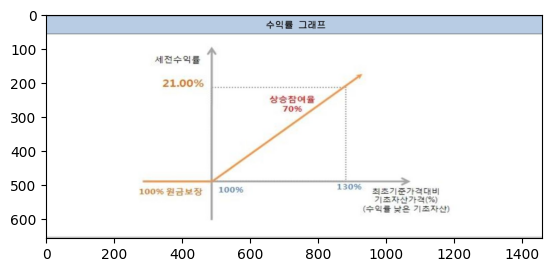

주어진 그래프는 세전수익률과 기준기준가격대비 기준자산가격의 관계를 보여주고 있습니다. 기준자산가격이 100%일 때의 세전수익률은 21%이며, 기준자산가격이 130%가 되면
세전수익률은 약 70%에 달할 것으로 예상됩니다. 이 그래프를 통해 수익률이 기준자산가격에 비례하여 증가하는 모습을 확인할 수 있습니다.
metadata:
 {'img_path': './fig/figure-3-2.jpg', 'category': 'Image', 'image_base64': '', 'id':
'898a1a24-c3cb-4d93-aba5-9dfad6513b7d', 'origin_image': ''}

-----------------------------------------------
3. Category: Image, Chunk: 151 Characters
-----------------------------------------------


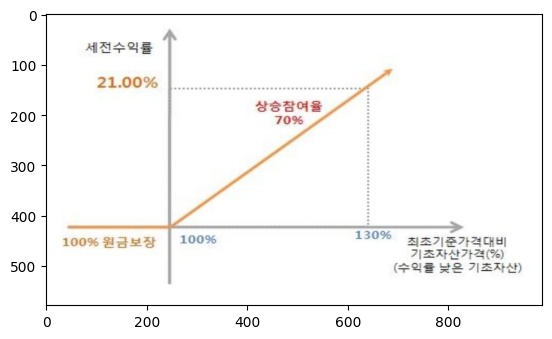

이 그래프는 적주기준가격대비 기준자산가격(%)에 따른 상승률여율을 보여주고 있습니다. 원금보전 100%에서는 상승률이 0%이지만, 적주기준가격대비가 130%로 높아질수록
상승률여율은 최대 21%까지 증가합니다. 이를 통해 위험과 수익 간의 상관관계를 확인할 수 있습니다.
metadata:
 {'img_path': './fig/figure-3-3.jpg', 'category': 'Image', 'image_base64': '', 'id':
'2d32a0bf-5325-4a32-9d5f-43290b23ae1a', 'origin_image': ''}


In [80]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)

print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts)